# Spatiotemporal CNN-RNN Proxy Model for CO2 Monitoring
### Misael M. Morales, 2023
***

In [1]:
from utils import *
check_tensorflow_gpu()

proxy = SpatiotemporalCO2()
proxy.__dict__

... Checking Tensorflow Version ...
Tensorflow built with CUDA? True
TF: 2.10.0 | CUDA: 64_112 | cuDNN: 64_8
# GPU available: 1 (Quadro M6000 24GB, pci )


{'input_features_dir': 'simulations2D/input_features',
 'output_targets_dir': 'simulations2D/output_targets',
 'x_data_labels': ['Poro', 'LogPerm', 'Facies', 'Wells'],
 'y_data_labels': ['Pressure', 'Saturation'],
 'return_data': False,
 'n_realizations': 1000,
 'x_channels': 4,
 'y_channels': 2,
 'timesteps': 60,
 'dim': 64,
 'test_size': 0.25,
 't_samples': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60],
 'cnn_filters': [16, 64, 256],
 'rnn_filters': [256, 64, 16],
 'optimizer': <tensorflow_addons.optimizers.weight_decay_optimizers.AdamW at 0x257f0025af0>,
 'criterion': <bound method SpatiotemporalCO2.custom_loss of <utils.SpatiotemporalCO2 object at 0x00000257CA3CC7F0>>,
 'L1L2_split': 0.25,
 'loss_alpha': 0.75,
 'regular': <keras.regularizers.L1 at 0x257f082bd60>,
 'leaky_slope': 0.25,
 'num_epochs': 200,
 'batch_size': 30,
 'lr_decay': 15,
 'verbose': 0}

In [2]:
proxy.load_data()
proxy.process_data(subsample=None)

X: (1000, 64, 64, 4) | y: (1000, 60, 64, 64, 2)
MinMax Normalization Done!
Train - X: (750, 64, 64, 4) | y: (750, 11, 64, 64, 2)
Test  - X: (250, 64, 64, 4) | y: (250, 11, 64, 64, 2)


In [3]:
proxy.make_model()

In [4]:
proxy.training()

# Parameters: 69,425,918 | Batch size: 30 
Epoch: [10/200] - Loss: 0.0599 - Val Loss: 0.1110
Epoch: [20/200] - Loss: 0.0369 - Val Loss: 0.0844
Epoch: [30/200] - Loss: 0.0271 - Val Loss: 0.0596
Epoch: [40/200] - Loss: 0.0221 - Val Loss: 0.0531
Epoch: [50/200] - Loss: 0.0179 - Val Loss: 0.0483
Epoch: [60/200] - Loss: 0.0152 - Val Loss: 0.0473
Epoch: [70/200] - Loss: 0.0152 - Val Loss: 0.0461
Epoch: [80/200] - Loss: 0.0130 - Val Loss: 0.0455
Epoch: [90/200] - Loss: 0.0126 - Val Loss: 0.0465
Epoch: [100/200] - Loss: 0.0110 - Val Loss: 0.0433
Epoch: [110/200] - Loss: 0.0107 - Val Loss: 0.0455
Epoch: [120/200] - Loss: 0.0075 - Val Loss: 0.0411
Epoch: [130/200] - Loss: 0.0074 - Val Loss: 0.0411
Epoch: [140/200] - Loss: 0.0072 - Val Loss: 0.0410
Epoch: [150/200] - Loss: 0.0077 - Val Loss: 0.0410
Epoch: [160/200] - Loss: 0.0075 - Val Loss: 0.0410
Epoch: [170/200] - Loss: 0.0072 - Val Loss: 0.0410
Epoch: [180/200] - Loss: 0.0076 - Val Loss: 0.0411
Epoch: [190/200] - Loss: 0.0082 - Val Loss: 0.04

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [8]:
proxy.predictions()

8/8 [==============================] - 1s 181ms/step
Train pred: (750, 11, 64, 64, 2) | Test pred: (250, 11, 64, 64, 2)
MSE  | Train: 1.20e-03, Test: 4.30e-03
SSIM | Train: 95.91, Test: 86.96


24/24 [==============================] - 0s 6ms/step
Latent shape: (750, 8, 8, 256)


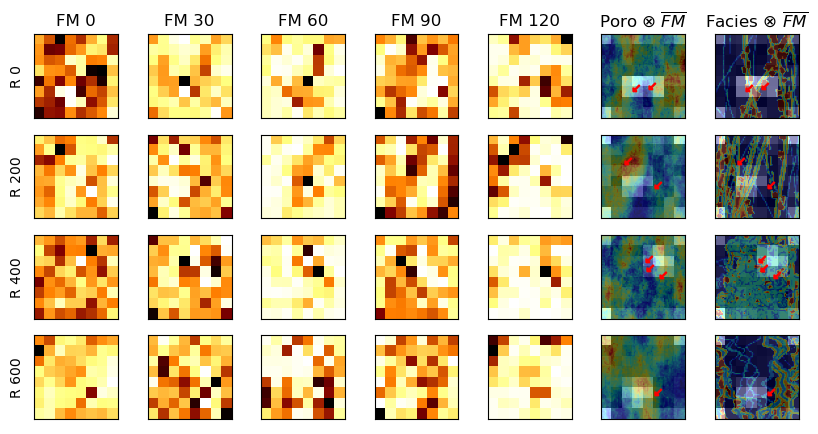

In [9]:
proxy.latent_space()

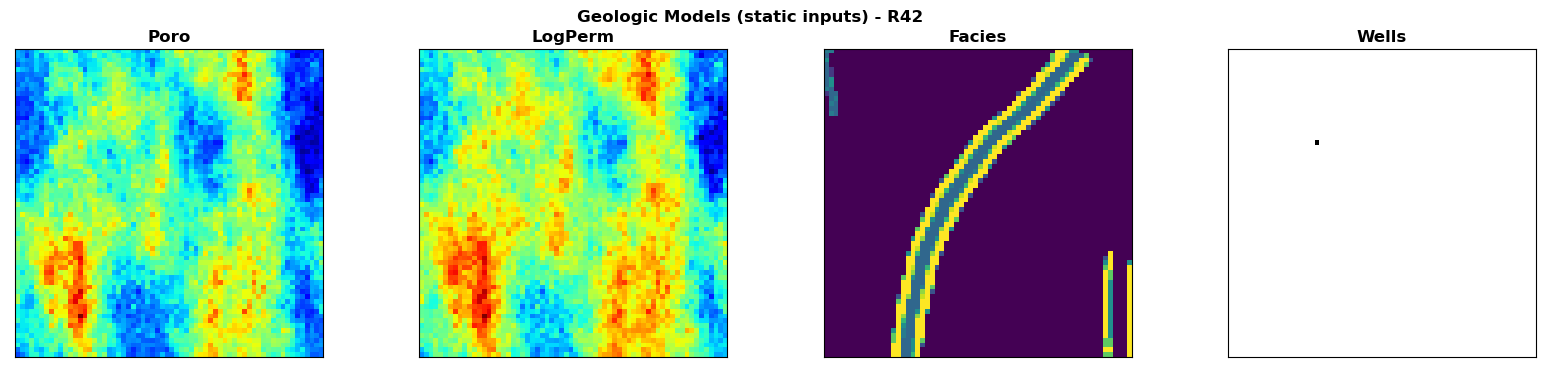

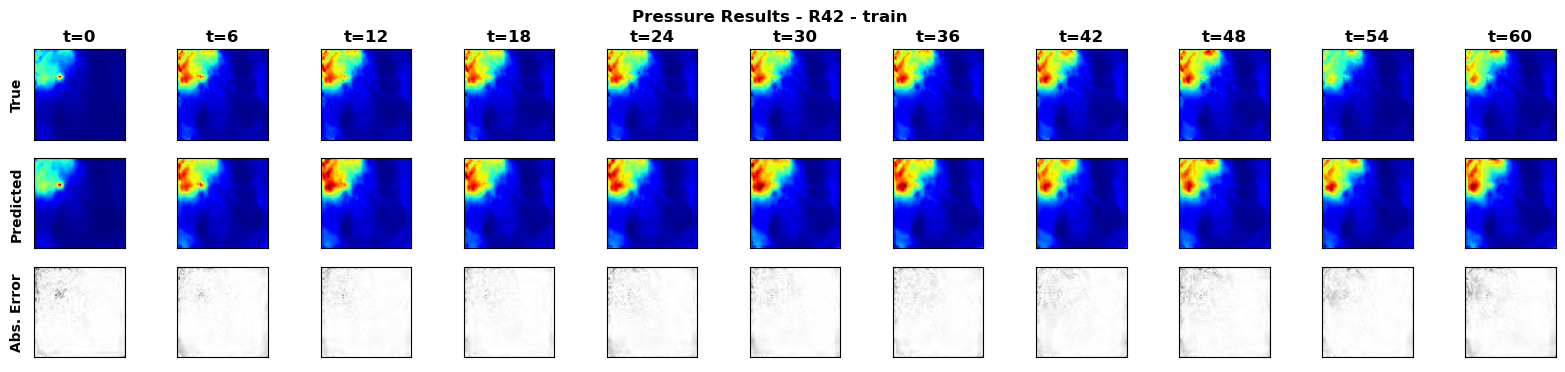

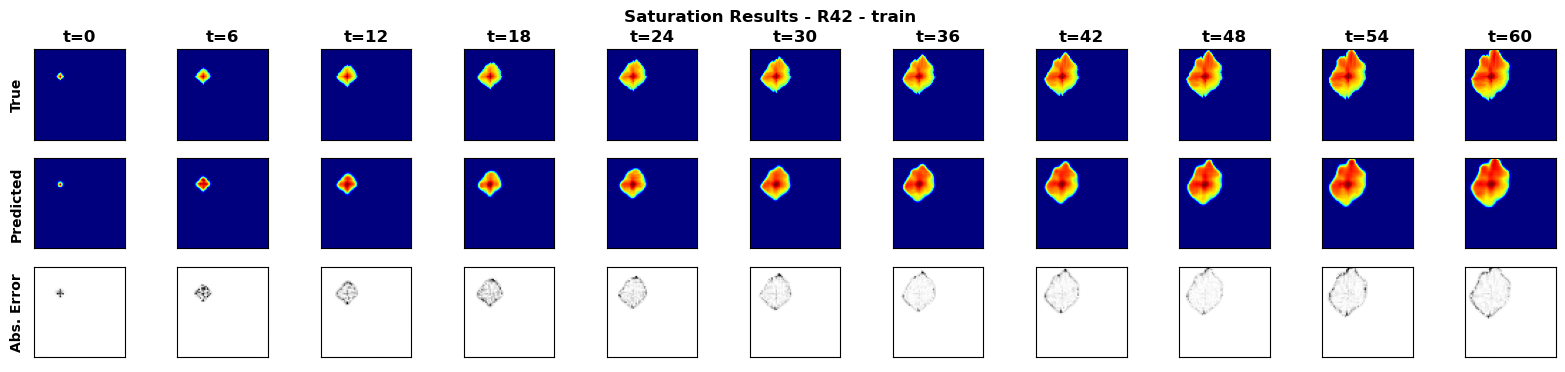

In [10]:
proxy.plot_single_results(42, 'train')

Train - Mean CO2 Injected: True: 5356.03 | Pred: 5396.20
Test  - Mean CO2 Injected: True: 5226.50 | Pred: 4951.48


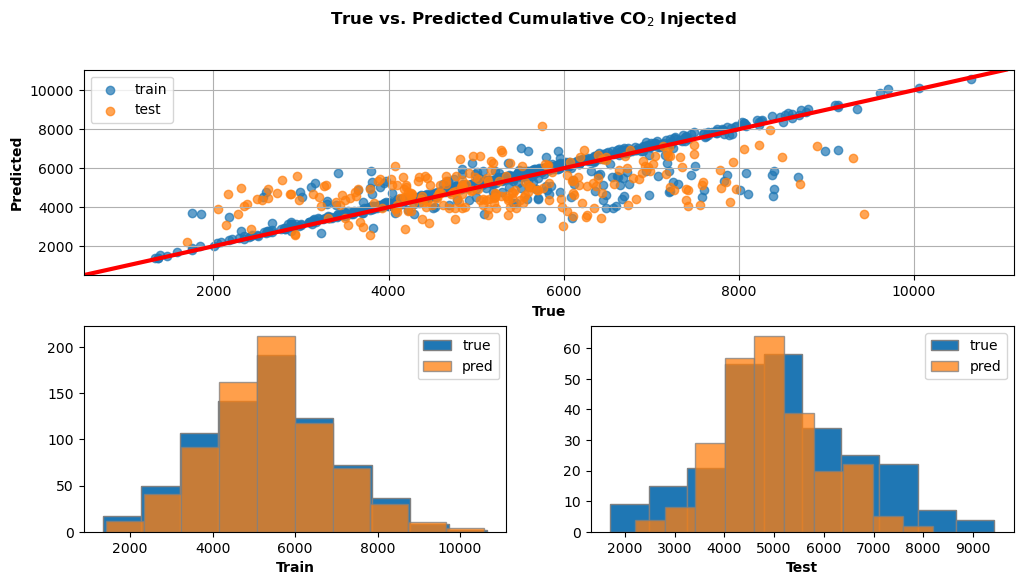

In [11]:
proxy.cumulative_co2()

***
# END